In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import string
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score,accuracy_score
from sklearn.mixture import GaussianMixture

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Load CSV dataset
PATH_DATASET = "train.csv"
df_dataset = pd.read_csv(PATH_DATASET,sep=",",encoding="ISO-8859-1")

In [ ]:
df_dataset.columns

Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)'],
      dtype='object')

In [ ]:
def modificar_dataset(df_dataset):
    df_dataset = df_dataset.rename(columns={"Time of Tweet": "time_of_tweet", "Age of User": "age_user", "Population -2020": "population_2020", "Land Area (Km²)": "land_area_km", "Density (P/Km²)": "density_p_km"})
    df_dataset["sentiment"] = df_dataset["sentiment"].astype("category")
    df_dataset["time_of_tweet"] = df_dataset["time_of_tweet"].astype("category")
    df_dataset["age_user"] = df_dataset["age_user"].astype("category")
    df_dataset["Country"] = df_dataset["Country"].astype("category")
    df_dataset_format = df_dataset[["sentiment", "text", "age_user", "population_2020", "land_area_km", "density_p_km", "time_of_tweet", "Country"]]
    return df_dataset_format

In [ ]:
df_dataset.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [ ]:
df_dataset_format = modificar_dataset(df_dataset)

In [ ]:
df_dataset_format.head()

,sentiment,text,age_user,population_2020,land_area_km,density_p_km,time_of_tweet,Country
0,neutral,"I`d have responded, if I were going",0-20,38928346,652860.0,60,morning,Afghanistan
1,negative,Sooo SAD I will miss you here in San Diego!!!,21-30,2877797,27400.0,105,noon,Albania
2,negative,my boss is bullying me...,31-45,43851044,2381740.0,18,night,Algeria
3,negative,what interview! leave me alone,46-60,77265,470.0,164,morning,Andorra
4,negative,"Sons of ****, why couldn`t they put them on t...",60-70,32866272,1246700.0,26,noon,Angola


In [ ]:
df_dataset_format.describe(include="all")

,sentiment,text,age_user,population_2020,land_area_km,density_p_km,time_of_tweet,Country
count,27481,27480,27481,2.748100e+04,2.748100e+04,27481.000000,27481,27481
unique,3,27480,6,NaN,NaN,NaN,3,195
top,neutral,"I`d have responded, if I were going",0-20,NaN,NaN,NaN,morning,Afghanistan
freq,11118,1,4581,NaN,NaN,NaN,9161,149
mean,NaN,NaN,NaN,4.018497e+07,6.621730e+05,357.686583,NaN,NaN
std,NaN,NaN,NaN,1.504946e+08,1.807425e+06,2013.750702,NaN,NaN
min,NaN,NaN,NaN,8.010000e+02,0.000000e+00,2.000000,NaN,NaN
25%,NaN,NaN,NaN,1.968001e+06,2.281000e+04,35.000000,NaN,NaN
50%,NaN,NaN,NaN,8.655535e+06,1.118900e+05,89.000000,NaN,NaN
75%,NaN,NaN,NaN,2.843594e+07,5.279700e+05,214.000000,NaN,NaN


Limpieza de textos

In [ ]:
df_dataset_format["text"]

0                      I`d have responded, if I were going
1            Sooo SAD I will miss you here in San Diego!!!
2                                my boss is bullying me...
3                           what interview! leave me alone
4         Sons of ****, why couldn`t they put them on t...
                               ...                        
27476     wish we could come see u on Denver  husband l...
27477     I`ve wondered about rake to.  The client has ...
27478     Yay good for both of you. Enjoy the break - y...
27479                           But it was worth it  ****.
27480       All this flirting going on - The ATG smiles...
Name: text, Length: 27481, dtype: object

Encontrar filas contextos Null o Nan

In [ ]:
filas_con_nan = df_dataset_format[df_dataset_format.isna().any(axis=1)]

In [ ]:
filas_con_nan

,sentiment,text,age_user,population_2020,land_area_km,density_p_km,time_of_tweet,Country
314,neutral,NaN,31-45,2540905,823000.0,3,night,Namibia


In [ ]:
df_dataset_format["text"].fillna("", inplace=True)

In [ ]:
def clean_text(text):
    # Convertir el texto a minúsculas
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    text = text.translate(str.maketrans('', '', string.punctuation))
    # Eliminar caracteres especiales y números
    text = re.sub(r"[^a-z\s]", "", text)


    # Eliminar stopwords
    stop_words = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])
    # Lematización
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [ ]:
df_dataset_format["text_clean"] = df_dataset_format["text"].apply(clean_text)

In [ ]:
df_dataset_format["sentiment_codes"] = pd.Categorical(df_dataset_format["sentiment"]).codes

In [ ]:
df_dataset_format["sentiment_codes"].unique()

array([1, 0, 2], dtype=int8)

In [ ]:
df_dataset_format["text_clean"][:20]

0                                    id responded going
1                               sooo sad miss san diego
2                                          bos bullying
3                                 interview leave alone
4                son couldnt put release already bought
5            shameless plugging best ranger forum earth
6                            feeding baby fun smile coo
7                                            soooo high
8                                                      
9             journey wow u became cooler hehe possible
10    much love hopeful reckon chance minimal p im n...
11      really really like song love story taylor swift
12                  sharpie running dangerously low ink
13                     want go music tonight lost voice
14                                     test test lg env
15                                      uh oh sunburned
16               sok trying plot alternative speak sigh
17    ive sick past day thus hair look wierd did

In [ ]:
def vectorizar_texto(texto):
    vectorizer = CountVectorizer(stop_words="english",min_df=5)
    X = vectorizer.fit_transform(texto)
    df_bow = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    return df_bow,vectorizer

In [ ]:
def vectorizar_tfidf(texto):
    vectorizer = TfidfVectorizer(stop_words="english",min_df=5)
    X = vectorizer.fit_transform(texto)
    df_bow = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    return df_bow,vectorizer

In [ ]:
df_bow,vectorizer = vectorizar_texto(df_dataset_format["text_clean"])

In [ ]:
vocabulario = vectorizer.vocabulary_

In [ ]:
vocabulario

{'id': 1645,
 'going': 1363,
 'sooo': 3058,
 'sad': 2813,
 'miss': 2132,
 'san': 2825,
 'diego': 894,
 'bos': 370,
 'interview': 1704,
 'leave': 1890,
 'son': 3052,
 'release': 2714,
 'bought': 376,
 'best': 294,
 'ranger': 2654,
 'forum': 1262,
 'earth': 1012,
 'feeding': 1175,
 'baby': 214,
 'fun': 1297,
 'smile': 3014,
 'soooo': 3059,
 'high': 1547,
 'journey': 1773,
 'wow': 3729,
 'cooler': 711,
 'hehe': 1527,
 'possible': 2533,
 'love': 1989,
 'hopeful': 1599,
 'reckon': 2684,
 'chance': 530,
 'im': 1659,
 'gonna': 1370,
 'cake': 468,
 'stuff': 3178,
 'really': 2675,
 'like': 1920,
 'song': 3053,
 'story': 3156,
 'taylor': 3276,
 'swift': 3238,
 'running': 2807,
 'low': 1997,
 'want': 3606,
 'music': 2204,
 'tonight': 3393,
 'lost': 1983,
 'voice': 3583,
 'test': 3302,
 'uh': 3508,
 'oh': 2316,
 'sunburned': 3203,
 'trying': 3449,
 'plot': 2503,
 'speak': 3084,
 'sigh': 2953,
 'ive': 1726,
 'sick': 2950,
 'past': 2411,
 'day': 828,
 'hair': 1462,
 'look': 1971,
 'didnt': 891,
 'ha

In [ ]:
df_bow.head(10)

,aaaah,aah,abandoned,ability,abit,able,absolutely,abt,ac,academy,...,yu,yucky,yum,yummy,yup,zealand,zero,zombie,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_tfidf, vectorizer_tfidf = vectorizar_tfidf(df_dataset_format["text_clean"])

In [ ]:
df_tfidf.shape

(27481, 3799)

In [ ]:
df_tfidf.describe()

,aaaah,aah,abandoned,ability,abit,able,absolutely,abt,ac,academy,...,yu,yucky,yum,yummy,yup,zealand,zero,zombie,zone,zoo
count,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,...,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000
mean,0.000088,0.000102,0.000111,0.000177,0.000115,0.001289,0.000796,0.000333,0.000325,0.000111,...,0.000164,0.000156,0.000726,0.000699,0.000487,0.000118,0.000233,0.000224,0.000151,0.000158
std,0.006661,0.007585,0.008341,0.010901,0.007851,0.023058,0.020720,0.012365,0.012609,0.007831,...,0.009416,0.009289,0.020074,0.018459,0.016719,0.007552,0.011947,0.010890,0.009974,0.009446
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.655016,0.632222,0.712910,0.885499,0.590480,0.856535,1.000000,0.633683,0.655691,0.784603,...,0.726104,0.744764,1.000000,0.753368,1.000000,0.655262,0.809740,0.695886,1.000000,0.753043


In [ ]:
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(df_tfidf)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps["pca"]

In [ ]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
df_pca_components = pd.DataFrame(
    data=modelo_pca.components_,
    columns=df_tfidf.columns,
    index=["PC{}".format(i+1) for i in range(modelo_pca.n_components_)],
)

In [ ]:
df_pca_components

,aaaah,aah,abandoned,ability,abit,able,absolutely,abt,ac,academy,...,yu,yucky,yum,yummy,yup,zealand,zero,zombie,zone,zoo
PC1,-0.003182,0.001115,-0.003222,-0.002589,-0.005263,-0.015381,-0.001996,-0.007864,-0.009768,-0.000961,...,0.000284,-0.000800,-0.002736,0.004401,0.002205,0.008878,-0.000603,0.000193,-0.001717,0.002466
PC2,-0.003104,0.001595,-0.005159,0.003678,0.000223,0.011810,-0.001388,0.001455,-0.001676,0.012754,...,-0.002819,0.003147,-0.045290,-0.050917,0.008436,0.023304,0.006274,0.015863,-0.000311,-0.002936
PC3,-0.001190,-0.003968,0.006323,-0.005181,0.000936,-0.032107,0.020881,-0.012619,0.002588,0.009606,...,0.002317,0.006453,0.058027,0.054907,0.008855,0.010496,-0.007161,0.006955,0.003519,-0.000246
PC4,-0.004008,0.001716,-0.004030,-0.001073,-0.001462,0.001525,0.019815,0.008158,-0.009392,-0.006633,...,-0.001512,-0.007388,-0.007349,-0.013599,-0.006166,-0.000333,0.005474,0.000668,0.003363,0.003399
PC5,-0.003097,-0.005091,-0.008674,0.006644,-0.004524,0.005666,0.005396,-0.000042,0.003403,0.003907,...,-0.006514,-0.004069,0.063819,0.059372,-0.000817,-0.007186,0.007803,-0.049321,0.002647,-0.004469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC3795,0.001421,0.001051,0.000389,-0.000273,-0.000931,0.000023,0.001099,-0.000772,0.000056,-0.002595,...,-0.000626,0.000701,0.001549,0.002393,0.000700,-0.001398,0.002031,0.051049,0.000548,-0.000326
PC3796,-0.000473,0.000462,-0.000129,-0.000088,0.019671,-0.000077,0.000510,0.000717,0.000511,0.001219,...,-0.000991,0.000159,0.000503,0.000216,0.005110,0.001109,0.000062,0.000166,-0.000186,-0.001151
PC3797,0.001052,-0.000710,-0.000264,0.002168,0.000236,-0.001690,0.009402,0.000839,0.000009,0.000790,...,-0.000129,0.002285,0.003872,0.021141,0.000303,0.000544,-0.000865,0.002170,0.000959,0.001658
PC3798,-0.000194,-0.000125,-0.002354,0.000726,-0.000355,0.002025,0.000176,-0.000412,0.000512,-0.000153,...,0.000062,0.000242,-0.000969,0.017454,-0.000422,-0.000561,0.000206,-0.000751,-0.000452,-0.000044


In [ ]:
print("Porcentaje de varianza explicada por cada componente")
print(modelo_pca.explained_variance_ratio_)
# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(modelo_pca.explained_variance_ratio_)

# Print cumulative explained variance ratio
print("Porcentaje de varianza acumulada por cada componente")
print(cumulative_variance_ratio)

In [ ]:
cumulative_variance_ratio[2829]

In [ ]:
np.where(cumulative_variance_ratio>0.85)

In [ ]:
# Asumiendo df_usa_arrests_scaled como tus datos escalados
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(df_tfidf)
distances, indices = neighbors_fit.kneighbors(df_tfidf)

# Ordenar y plotear las distancias
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances[:5000])
plt.show()

In [ ]:
plt.plot(distances[:2000])
plt.show()

In [ ]:
distances.shape

In [ ]:
# Suponiendo que 'X' son tus datos de 4000 columnas
X_embedded = TSNE(n_components=2).fit_transform(df_tfidf)

Primera Evaluación

In [ ]:
dbscan_1 = DBSCAN(eps=0.1, min_samples=2).fit(df_tfidf)
y_dbs1 = dbscan_1.labels_

In [ ]:
def mostrar_cantidad_grupos(labels):
    unique, counts = np.unique(labels, return_counts=True)
    iterator = dict(zip(unique, counts))
    for el in iterator:
        print("Grupo ",(el+1) if el!=-1 else "Ruido",": ",iterator[el]," Porcentage: ",(iterator[el]/len(labels)*100).round(2),"%")

In [ ]:
def graficar_clasificacion(X_embedded, y_dbs1):
    # Visualización
    plt.figure(figsize=(10, 6))
    plt.scatter(
        X_embedded[:, 0], X_embedded[:, 1], c=y_dbs1, cmap="viridis"
    )  # 'y_dbs1' son tus etiquetas de cluster
    plt.colorbar()
    plt.title("Visualización de DBSCAN con t-SNE")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.show()

In [ ]:
def mostrar_metricas(y_dbs1):
    indices_no_ruido_1 = y_dbs1 != -1

    score = silhouette_score(df_tfidf[indices_no_ruido_1], y_dbs1[indices_no_ruido_1])
    print("Silhouette Score Clasificación sin considerar el ruido: ", score)

In [ ]:
mostrar_cantidad_grupos(y_dbs1)

In [ ]:
graficar_clasificacion(X_embedded, y_dbs1)

In [ ]:
mostrar_metricas(y_dbs1)

Silhouette Score Clasificación sin considerar el ruido:  0.999999999468792


Segunda Evaluación

In [ ]:
dbscan_2 = DBSCAN(eps=0.995, min_samples=45).fit(df_tfidf)
y_dbs2 = dbscan_2.labels_

In [ ]:
mostrar_cantidad_grupos(y_dbs2)

In [ ]:
graficar_clasificacion(X_embedded, y_dbs2)

In [ ]:
mostrar_metricas(y_dbs2)

Silhouette Score Clasificación sin considerar el ruido:  -0.19474687672038937


Tercera Evaluación

In [ ]:
dbscan_3 = DBSCAN(eps=0.01, min_samples=500).fit(df_tfidf)
y_dbs3 = dbscan_3.labels_

In [ ]:
mostrar_cantidad_grupos(y_dbs3)

Grupo  Ruido :  27481  Porcentage:  100.0 %


In [ ]:
graficar_clasificacion(X_embedded, y_dbs3)

In [ ]:
mostrar_metricas(y_dbs3)

Mixturas Gaussianas

In [ ]:
gm_1 = GaussianMixture(n_components=3, random_state=0, covariance_type="diag").fit(
    df_tfidf
)
print(gm_1.means_)

print(gm_1.covariances_)

y_gmm1 = gm_1.predict(df_tfidf)

[[3.70780047e-04 8.48761999e-05 4.66974677e-04 ... 3.15967868e-04
  3.72430141e-04 2.01388015e-04]
 [0.00000000e+00 1.72210199e-04 0.00000000e+00 ... 3.12747193e-04
  0.00000000e+00 2.31918009e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.16352005e-04 0.00000000e+00]]
[[1.86902715e-04 4.82076109e-05 2.92542932e-04 ... 1.71333387e-04
  1.88583491e-04 9.01322940e-05]
 [1.00000000e-06 9.86263224e-05 1.00000000e-06 ... 1.65459602e-04
  1.00000000e-06 1.44389028e-04]
 [1.00000000e-06 1.00000000e-06 1.00000000e-06 ... 1.00000000e-06
  1.91242763e-04 1.00000000e-06]]


In [ ]:
mostrar_cantidad_grupos(y_gmm1)

Grupo  1 :  6554  Porcentage:  23.85 %
Grupo  2 :  13024  Porcentage:  47.39 %
Grupo  3 :  7903  Porcentage:  28.76 %


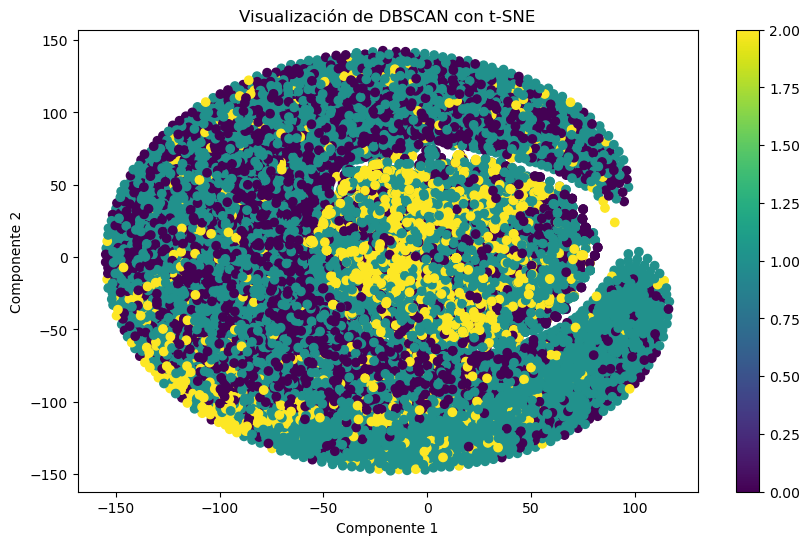

In [ ]:
graficar_clasificacion(X_embedded, y_gmm1)

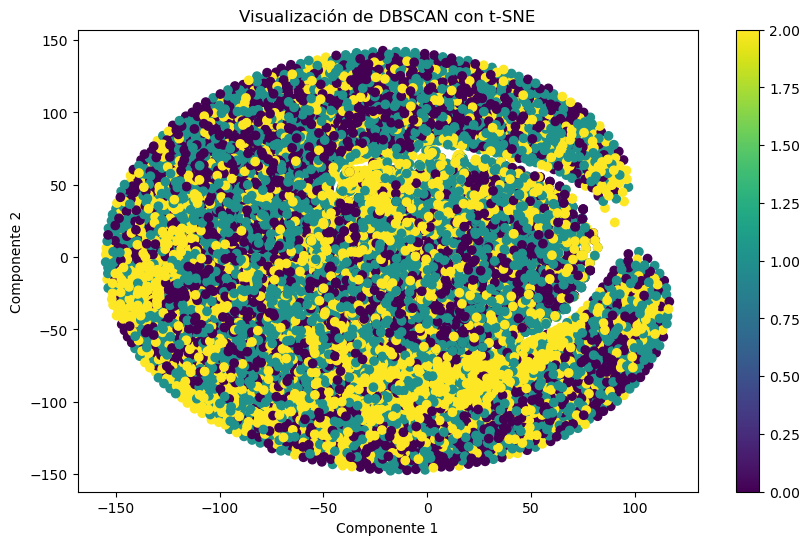

In [ ]:
graficar_clasificacion(X_embedded, df_dataset_format["sentiment_codes"])

In [ ]:
def mostrar_lista_accuracy(labels):
    mapeo_1 = {0:0,1:2,2:1}
    mapeo_2 = {0:1,1:0,2:2}
    mapeo_3 = {0:1,1:2,2:0}
    mapeo_4 = {0:2,1:1,2:0}
    mapeo_5 = {0:2,1:0,2:1}
    y_gmm1_mapped = np.vectorize(mapeo_1.get)(labels)
    y_gmm2_mapped = np.vectorize(mapeo_2.get)(labels)
    y_gmm3_mapped = np.vectorize(mapeo_3.get)(labels)
    y_gmm4_mapped = np.vectorize(mapeo_4.get)(labels)
    y_gmm5_mapped = np.vectorize(mapeo_5.get)(labels)
    precision = accuracy_score(df_dataset_format["sentiment_codes"], y_gmm1_mapped)

    print(f"La precisión del modelo es: {precision}")
    precision = accuracy_score(df_dataset_format["sentiment_codes"], y_gmm2_mapped)

    print(f"La precisión del modelo es: {precision}")
    precision = accuracy_score(df_dataset_format["sentiment_codes"], y_gmm3_mapped)

    print(f"La precisión del modelo es: {precision}")
    precision = accuracy_score(df_dataset_format["sentiment_codes"], y_gmm4_mapped)

    print(f"La precisión del modelo es: {precision}")
    precision = accuracy_score(df_dataset_format["sentiment_codes"], y_gmm5_mapped)

    print(f"La precisión del modelo es: {precision}")

In [ ]:
mostrar_lista_accuracy(y_gmm1)

La precisión del modelo es: 0.3204759652123285
La precisión del modelo es: 0.37116553254976165
La precisión del modelo es: 0.29220188493868493
La precisión del modelo es: 0.30835850223790984
La precisión del modelo es: 0.342927841053819


In [ ]:
mostrar_metricas(y_gmm1)

Silhouette Score Clasificación sin considerar el ruido:  0.00928421204849256


In [ ]:

#kmeans
#Seleccion de clústers
from sklearn.cluster import KMeans
scaler = StandardScaler()
datos_escalado = scaler.fit_transform(df_tfidf)
datos_escalado

array([[-0.01327664, -0.01342884, -0.01335228, ..., -0.02053092,
        -0.01514413, -0.0167208 ],
       [-0.01327664, -0.01342884, -0.01335228, ..., -0.02053092,
        -0.01514413, -0.0167208 ],
       [-0.01327664, -0.01342884, -0.01335228, ..., -0.02053092,
        -0.01514413, -0.0167208 ],
       ...,
       [-0.01327664, -0.01342884, -0.01335228, ..., -0.02053092,
        -0.01514413, -0.0167208 ],
       [-0.01327664, -0.01342884, -0.01335228, ..., -0.02053092,
        -0.01514413, -0.0167208 ],
       [-0.01327664, -0.01342884, -0.01335228, ..., -0.02053092,
        -0.01514413, -0.0167208 ]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

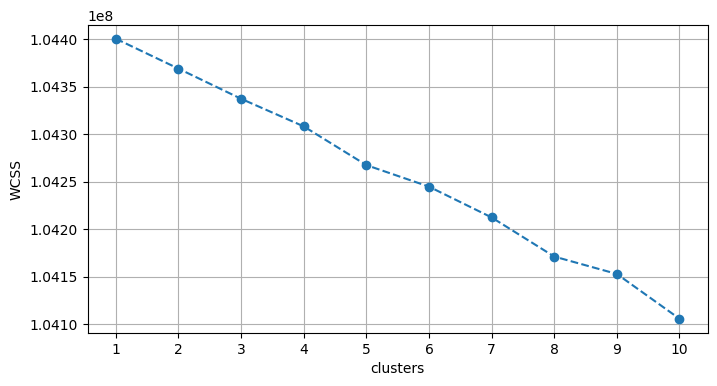

In [ ]:
def calcular_wcss(data):
    wcss = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

wcss = calcular_wcss(datos_escalado)


plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [ ]:

kmeans = KMeans(n_clusters=3, random_state=42)

kmeans.fit(datos_escalado)

df_dataset_format['kmeans_labels'] = kmeans.predict(datos_escalado)
df_dataset_format.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,sentiment,text,age_user,population_2020,land_area_km,density_p_km,time_of_tweet,Country,text_clean,sentiment_codes,kmeans_labels
0,neutral,"I`d have responded, if I were going",0-20,38928346,652860.0,60,morning,Afghanistan,id responded going,1,2
1,negative,Sooo SAD I will miss you here in San Diego!!!,21-30,2877797,27400.0,105,noon,Albania,sooo sad miss san diego,0,2
2,negative,my boss is bullying me...,31-45,43851044,2381740.0,18,night,Algeria,bos bullying,0,2
3,negative,what interview! leave me alone,46-60,77265,470.0,164,morning,Andorra,interview leave alone,0,2
4,negative,"Sons of ****, why couldn`t they put them on t...",60-70,32866272,1246700.0,26,noon,Angola,son couldnt put release already bought,0,2


In [ ]:
ss= silhouette_score(datos_escalado, df_dataset_format['kmeans_labels'])
print(f'Silhouette Score: {ss}')

Silhouette Score: 0.25623626690661866
